# Interactive Altair Plots

In [1]:
# data cleaning
import pandas as pd
import altair as alt

df = pd.read_csv('panic_attack_dataset.csv')
pd.set_option('display.max_rows', None)

missing_vals = df.isnull().sum()
missing_vals # quicker than manually checking df for them

# convert categorical data to numerical (Yes/No -> 1/0)
yes_no = ["Sweating", "Shortness_of_Breath", "Dizziness", "Trembling", "Smoking", "Therapy", "Medication", "Chest_Pain"]
df[yes_no] = df[yes_no].map(lambda x: 1 if x =="Yes" else 0) # assigns 1s to yes val and 0 to no

# removing non-binary individuals, making male=1, female=0
df = df[df["Gender"] != "Non-binary"].copy()
df.loc[:, "Gender"] = df["Gender"].map({"Female": 0, "Male": 1})

numerical = ["Heart_Rate", "Caffeine_Intake", "Exercise_Frequency", "Sleep_Hours", "Alcohol_Consumption"]

# function for classifying panic severity
def panic_severity(score):
    if score <=3:
        return "Low"
    elif 4 <= score <= 6:
        return "Medium"
    else:
        return "High"

# applying function to df
df.loc[:, "Panic_Severity"] = df["Panic_Score"].apply(panic_severity)


df = df.drop(columns=["ID"])

In [3]:
df.head()

,Age,Gender,Panic_Attack_Frequency,Duration_Minutes,Trigger,Heart_Rate,Sweating,Shortness_of_Breath,Dizziness,Chest_Pain,...,Medical_History,Medication,Caffeine_Intake,Exercise_Frequency,Sleep_Hours,Alcohol_Consumption,Smoking,Therapy,Panic_Score,Panic_Severity
0,56,0,9,5,Caffeine,134,1,0,1,1,...,Anxiety,0,2,3,6.4,5,1,1,5,Medium
1,46,1,8,9,Stress,139,1,1,0,0,...,PTSD,1,2,5,5.0,3,0,1,7,High
2,32,0,6,31,PTSD,141,0,1,1,0,...,Depression,0,4,0,8.3,8,0,1,7,High
3,60,1,5,20,Caffeine,109,1,1,0,0,...,Depression,0,3,3,5.3,8,0,0,1,Low
5,38,1,0,44,Social Anxiety,154,1,1,1,0,...,Depression,1,1,4,4.8,6,0,0,8,High


# Stress Induced Panic Attacks

More preproccessing, creation of new features 

In [7]:
# filter to stress-triggered panic attacks
df = df[df["Trigger"] == "Stress"].copy()

# symptom cols
symptom_cols = ["Sweating", "Shortness_of_Breath", "Dizziness", "Chest_Pain", "Trembling"]


# convert 1/0 to Yes/No just for this plot 
for col in symptom_cols:
    if df[col].dtype != 'object':
        df[col] = df[col].map({1: "Yes", 0: "No"})

        # melt symptom columns to long format
symptom_df = df.melt(
    id_vars=["Panic_Severity"],
    value_vars=symptom_cols,
    var_name="Category",
    value_name="Value")


# keep only 'Yes' symptoms
symptom_df = symptom_df[symptom_df["Value"] == "Yes"]
symptom_df["Type"] = "Symptom"
symptom_df["Label"] = symptom_df["Category"]  # just show symptom name


# lifestyle processing 
# bin lifestyle columns
df["Caffeine"] = pd.cut(df["Caffeine_Intake"],bins=[0, 2, 4, 7, 10], labels=["None", "Light", "High", "Very High"])
df["Alcohol"] = pd.cut(df["Alcohol_Consumption"], bins=[0, 2, 4, 7, 10], labels=["None", "Light", "High", "Very_High"])
df["Sleep"] = pd.cut(df["Sleep_Hours"], bins=[0, 6, 8, 24], labels=["Low", "Normal", "High"])


# melt lifestyle columns to long format
lifestyle_df = df.melt(
    id_vars=["Panic_Severity"],
    value_vars=["Caffeine", "Alcohol", "Sleep"],
    var_name="Category",
    value_name="Value")

lifestyle_df["Type"] = "Lifestyle"
lifestyle_df["Label"] = lifestyle_df["Category"] + ": " + lifestyle_df["Value"].astype(str)


# combine 
combined_df = pd.concat([symptom_df, lifestyle_df], ignore_index=True)

# radio toggling for symptom vs lifestyle
type_radio = alt.binding_radio(options=["Symptom", "Lifestyle"], name="View:")
type_selector = alt.param(bind=type_radio, name="TypeSelector", value="Symptom")


# dropdown for Panic_Severity
severity_dropdown = alt.binding_select(options=["Low", "Medium", "High"], name="Panic Severity:")
severity_selector = alt.param(bind=severity_dropdown, name="SeveritySelector", value="High")

In [8]:
# interactive chart with all tools
chart_count = alt.Chart(combined_df).mark_bar().encode(
    y=alt.Y("Label:N", title="Category / Value", sort='-x'),
    x=alt.X("count():Q", title="Count"),
    color=alt.Color("Panic_Severity:N", scale=alt.Scale(
        domain=["Low", "Medium", "High"],
        range=["green", "orange", "red"]
    )),
    tooltip=["Category", "Value", "count()"]
).add_params(
    type_selector,
    severity_selector
).transform_filter(
    (alt.datum.Type == type_selector) &
    (alt.datum.Panic_Severity == severity_selector)
).properties(
    title="Stress-Induced Panic Attacks: Compare Symptoms and Lifestyle",
    width=600,
    height=400
)

chart_count

alt.Chart(...)

# Potential Improvement: Stacked bar chart 

In [9]:
chart_proportion = alt.Chart(combined_df).mark_bar().encode(
    y=alt.Y("Label:N", title="Feature (Symptom or Lifestyle)", sort='-x'),
    x=alt.X("count():Q", stack="normalize", title="Proportion"),
    color=alt.Color("Panic_Severity:N", scale=alt.Scale(
        domain=["Low", "Medium", "High"],
        range=["green", "orange", "red"]
    )),
    tooltip=["Category", "Value", "Panic_Severity", "count()"]
).add_params(
    type_selector
).transform_filter(
    alt.datum.Type == type_selector
).properties(
    title="Stress-Induced Panic Attacks: Normalized View of Symptoms and Lifestyle by Severity",
    width=600,
    height=400
)
chart_proportion

alt.Chart(...)

# How sleep affects panic score

In [10]:
slider = alt.binding_range(min=4, max=10, step=0.5, name='Min Sleep Hours:')
sleep_param = alt.param(bind=slider, value=5)

chart = alt.Chart(df).mark_circle(size=60, opacity=0.6).encode(
    x=alt.X("Sleep_Hours:Q", title="Sleep Hours", scale=alt.Scale(domain=[4, 9.5])),
    y="Panic_Score:Q",
    color="Panic_Severity:N",
    tooltip=["Sleep_Hours", "Panic_Score", "Panic_Severity"]
).add_params(sleep_param).transform_filter(
    alt.datum.Sleep_Hours >= sleep_param
).properties(
    title="How Does Sleep Affect Panic Score?"
)

chart

alt.Chart(...)

In [11]:
line_df = df.groupby("Sleep_Hours", as_index=False)["Panic_Score"].mean()

line_chart = alt.Chart(line_df).mark_line(point=True).encode(
    x=alt.X("Sleep_Hours:Q", title="Sleep Hours", scale=alt.Scale(domain=[4, 9])),
    y=alt.Y("Panic_Score:Q", title="Average Panic Score"),
    tooltip=["Sleep_Hours", "Panic_Score"]
).properties(
    title="Average Panic Score by Sleep Hours"
)
line_chart

alt.Chart(...)

# Probably useless plot but kind of cool

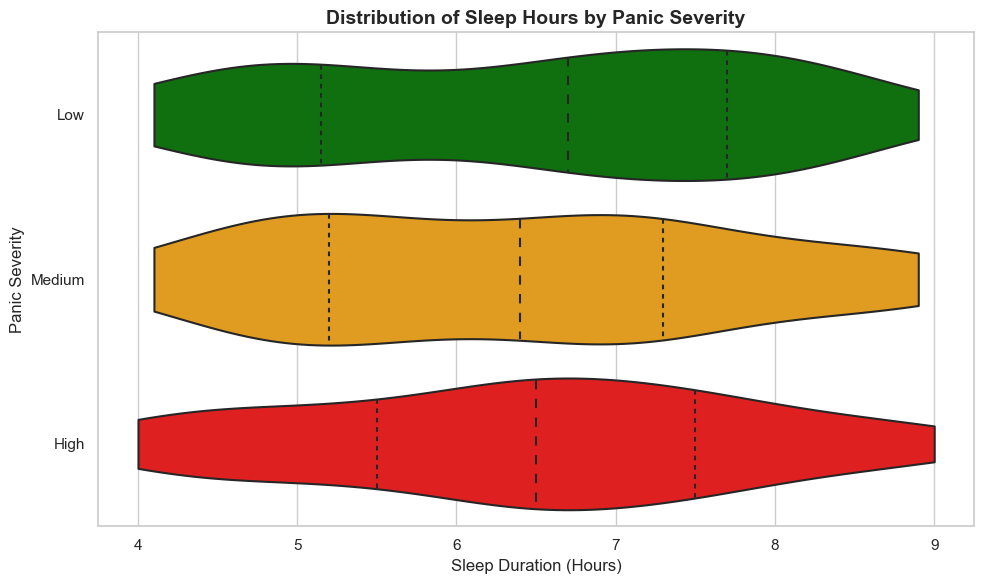

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# aesthetics
sns.set(style="whitegrid")

# ridge plot using seaborn
plt.figure(figsize=(10, 6))
g = sns.violinplot(
    x="Sleep_Hours",
    y="Panic_Severity",
    data=df,
    scale="width",
    inner="quartile",
    palette={"Low": "green", "Medium": "orange", "High": "red"},
    order=["Low", "Medium", "High"],
    cut=0)

plt.title("Distribution of Sleep Hours by Panic Severity", fontsize=14, weight='bold')
plt.xlabel("Sleep Duration (Hours)")
plt.ylabel("Panic Severity")

plt.tight_layout()
plt.show()